<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/test2/pi_test2_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# exercise 1

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
import os
import requests
import zipfile

torch.manual_seed(42);

def smooth_l1(prediction, target, w, e):
    error = prediction - target
    is_less_than = torch.abs(error) < w

    branch1 = w * torch.log(1 + torch.abs(error) / e)

    branch2 = torch.abs(error) - w + w * torch.log(1 + w / e)

    loss = branch1 * is_less_than + branch2 * (~is_less_than)

    return loss

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [ ]:
def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    else:
        assert False, 'Only zip files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    plt.rcParams['figure.figsize'] = figsize

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [ ]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

In [ ]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [ ]:
def display_anchors(fmap_w, fmap_h, s):
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                anchors[0] * bbox_scale)

In [ ]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [ ]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [ ]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [ ]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [ ]:
batch_size = 40
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [ ]:
device, net = try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [ ]:
w = torch.tensor([1.2], device = "cuda")
e = torch.tensor([0.8], device = "cuda")

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = lambda prediction, target: smooth_l1(prediction, target, w, e)


def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [ ]:
def train(net, train_iter, num_epochs, device):
  cls_acc_all = []
  bbox_mae_all = []
  net = net.to(device)
  for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    total_cls = 0
    total_cls_labels = 0
    total_bbox = 0
    total_bbox_labels = 0
    net.train()
    for features, target in train_iter:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        total_cls += cls_eval(cls_preds, cls_labels)
        total_cls_labels += cls_labels.numel()
        total_bbox += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        total_bbox_labels += bbox_labels.numel()
    cls_acc, bbox_mae = total_cls / total_cls_labels * 100, total_bbox / total_bbox_labels
    cls_acc_all.append(cls_acc)
    bbox_mae_all.append(bbox_mae)
    print(f'Epoch {epoch + 1}, Class accuracy {cls_acc:.2f}, Bounding box MAE {bbox_mae:.2e}')

  return cls_acc_all, bbox_mae_all

In [ ]:
def plot_cls_acc(cls_acc_all):
    epochs = range(1, len(cls_acc_all) + 1)
    plt.plot(epochs, cls_acc_all, 'b', label='Class accuracy')
    plt.title('Class accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def plot_bbox_mae(bbox_mae_all):
    epochs = range(1, len(bbox_mae_all) + 1)
    plt.plot(epochs, bbox_mae_all, 'b', label='Bounding box MAE')
    plt.title('Bounding box MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

In [ ]:
num_epochs = 15
cls_acc_all, bbox_mae_all = train(net, train_iter, num_epochs, device) #2 min

Epoch 1, Class accuracy 97.57, Bounding box MAE 5.13e-03
Epoch 2, Class accuracy 99.51, Bounding box MAE 4.96e-03
Epoch 3, Class accuracy 99.51, Bounding box MAE 4.90e-03
Epoch 4, Class accuracy 99.51, Bounding box MAE 4.84e-03
Epoch 5, Class accuracy 99.52, Bounding box MAE 4.77e-03
Epoch 6, Class accuracy 99.52, Bounding box MAE 4.67e-03
Epoch 7, Class accuracy 99.53, Bounding box MAE 4.54e-03
Epoch 8, Class accuracy 99.55, Bounding box MAE 4.37e-03
Epoch 9, Class accuracy 99.57, Bounding box MAE 4.20e-03
Epoch 10, Class accuracy 99.59, Bounding box MAE 4.07e-03
Epoch 11, Class accuracy 99.60, Bounding box MAE 3.99e-03
Epoch 12, Class accuracy 99.61, Bounding box MAE 3.93e-03
Epoch 13, Class accuracy 99.62, Bounding box MAE 3.86e-03
Epoch 14, Class accuracy 99.63, Bounding box MAE 3.80e-03
Epoch 15, Class accuracy 99.64, Bounding box MAE 3.74e-03


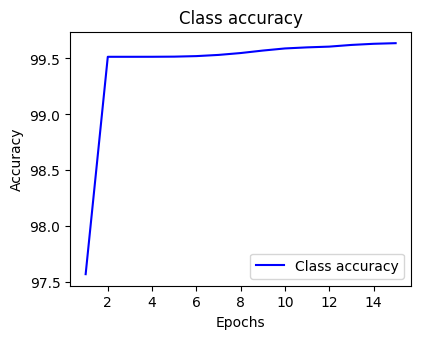

In [ ]:
set_figsize((4.4, 3.3))
plot_cls_acc(cls_acc_all)

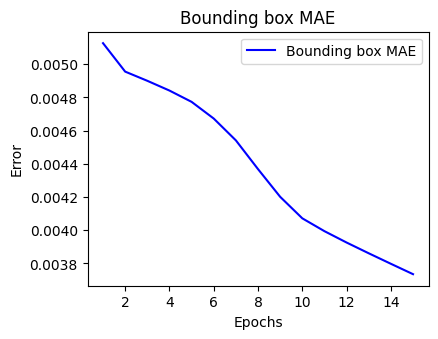

In [ ]:
plot_bbox_mae(bbox_mae_all)